In [19]:
import pandas as pd

# Subir archivo desde tu PC
#uploaded = files.upload()

# Obtener el nombre del archivo
# filename = list(uploaded.keys())[0]

# Leer CSV correctamente (separador coma)
df = pd.read_csv("../data/raw/df_cup_primary.csv", sep=",", encoding="latin-1", low_memory=False)

# Mostrar resultados
print(df.shape)
print(df.head())
print(df.info())


(3895, 129)
   COD_HOSPITAL  ID_BENEFICIARIO    SEXO FECHA_NACIMIENTO    ETNIA  \
0        114101         67717452   MUJER       1952-11-11  NINGUNO   
1        114101         67782077   MUJER       1948-02-02  NINGUNO   
2        116100         70825100  HOMBRE       1953-11-07  NINGUNO   
3        123100         77185788  HOMBRE       1964-11-05  NINGUNO   
4        105100         74846673   MUJER       1953-08-24  NINGUNO   

    PROVINCIA       COMUNA NACIONALIDAD                       PREVISION  \
0  CORDILLERA  PUENTE ALTO        CHILE  FONASA INSTITUCIONAL - (MAI) B   
1    SANTIAGO   LA FLORIDA        CHILE  FONASA INSTITUCIONAL - (MAI) B   
2      CURICO       MOLINA        CHILE  FONASA INSTITUCIONAL - (MAI) B   
3      OSORNO       OSORNO        CHILE  FONASA INSTITUCIONAL - (MAI) A   
4      LIMARI       OVALLE        CHILE  FONASA INSTITUCIONAL - (MAI) B   

             SERVICIO_SALUD  ... FECHAPROCEDIMIENTO1 FECHAINTERV1  \
0  METROPOLITANO SURORIENTE  ...               

FASE 1 Auditoría temporal (RA1) :
# 1) Detectar y parsear columnas de fecha
# 2) Elegir la mejor columna de evento temporal (evita FECHA_NACIMIENTO)
# 3) Ordenar, proponer frecuencia y auditar outliers
# 4) Dejar una mini-bitácora impresa de la auditoría

DF 2024 0       2024-09-20
1       2024-11-12
2       2024-06-24
3       2024-04-03
4       2024-03-01
           ...    
3890    2024-08-26
3891    2024-08-13
3892    2024-01-01
3893    2024-10-12
3894    2024-08-27
Name: FECHA_INGRESO, Length: 3809, dtype: object
== Columnas con pinta de fecha (ordenadas por conveniencia) ==
                col  score  coverage  n_non_null
      FECHA_INGRESO      2  1.000000        3809
          FECHAALTA      2  1.000000        3809
       FECHAINTERV1      2  0.485954        1851
FECHAPROCEDIMIENTO1      2  0.000000           0
     FECHATRASLADO1      0  0.269625        1027
     FECHATRASLADO2      0  0.129168         492
     FECHATRASLADO3      0  0.037280         142
     FECHATRASLADO4      0  0.012602          48
     FECHATRASLADO5      0  0.004726          18
     FECHATRASLADO6      0  0.002100           8
     FECHATRASLADO7      0  0.000525           2
     FECHATRASLADO8      0  0.000000           0
     FECHATRASLADO9      0  0.0000

C:\Users\musra\AppData\Local\Temp\ipykernel_6300\2146493573.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df_2024[c], errors='coerce', infer_datetime_format=True)
C:\Users\musra\AppData\Local\Temp\ipykernel_6300\2146493573.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df_2024[c], errors='coerce', infer_datetime_format=True)
C:\Users\musra\AppData\Local\Temp\ipykernel_6300\2146493573.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict ver

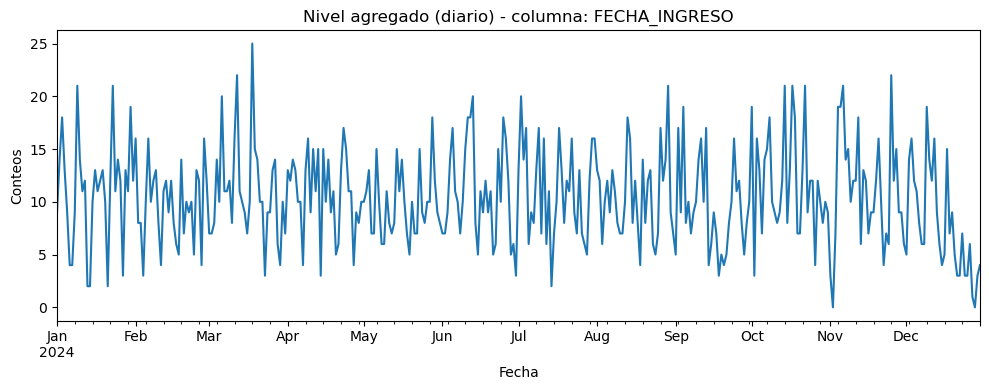


Artefacto auditoría: {'best_col': 'FECHA_INGRESO', 'range': ('2024-01-01', '2024-12-30'), 'span_days': 365, 'density': 0.9945205479452055, 'freq_propuesta': 'D', 'missing_ratio_resample': 0.0, 'n_outliers_IQR': 1}

'ts' listo para EDA (Fase 2). Primeras filas:
2024-01-01     9
2024-01-02    14
2024-01-03    18
2024-01-04    13
2024-01-05     9
2024-01-06     4
2024-01-07     4
2024-01-08     9
2024-01-09    21
2024-01-10    14
2024-01-11    11
2024-01-12    12
Freq: D, Name: y, dtype: int64


In [21]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_2024 = df[df['FECHA_INGRESO'].str.contains('2024', na=False)]

print(f"DF 2024 {df_2024['FECHA_INGRESO']}")

assert 'df' in globals(), "No encuentro el DataFrame 'df'. Carga tu CSV antes."

# 1) Candidatas a fecha (por nombre)
date_like = [c for c in df_2024.columns if re.search(r'fecha|date', c, flags=re.I)]
if not date_like:
    raise ValueError("No encontré columnas con nombre tipo 'FECHA'/'DATE'.")

# Palabras clave para fechas de evento (ingreso/alta/egreso/procedimiento/intervención/ocurrencia)
prefer = ['ingres', 'alta', 'egres', 'ocurr', 'proc', 'interv']
avoid  = ['nac']   # evitar fechas de nacimiento como serie objetivo

def score_col(col):
    name = col.lower()
    s = 0
    if any(p in name for p in prefer):
        s += 2
    if any(a in name for a in avoid):
        s -= 5
    return s

# 2) Intentar parsear todas y medir cobertura
parsed_info = []
for c in date_like:
    s = pd.to_datetime(df_2024[c], errors='coerce', infer_datetime_format=True)
    coverage = s.notna().mean()
    parsed_info.append({
        'col': c,
        'score': score_col(c),
        'coverage': coverage,
        'n_non_null': int(s.notna().sum())
    })

cand = pd.DataFrame(parsed_info).sort_values(['score','coverage','n_non_null'], ascending=[False, False, False])
best_col = cand.iloc[0]['col']
best_cov = cand.iloc[0]['coverage']

if best_cov < 0.01:
    raise ValueError(f"No hay columna de fecha con cobertura suficiente. Vistas: \n{cand}")

print("== Columnas con pinta de fecha (ordenadas por conveniencia) ==")
print(cand.to_string(index=False))
print("\nElegida como serie temporal objetivo:", best_col)

# df_2024 = df[df['FECHA_INGRESO'].dt.year == 2024]

# 3) Construir serie base (nivel diario por defecto) y auditar
dates = pd.to_datetime(df_2024[best_col], errors='coerce')
base = (pd.DataFrame({'date': dates})
        .dropna()
        .sort_values('date'))

# Si la columna tiene hora/minuto, la llevamos a fecha (día)
if (base['date'].dt.time != pd.to_datetime('00:00:00').time()).any():
    base['date'] = base['date'].dt.floor('D')

# Span temporal
dmin, dmax = base['date'].min(), base['date'].max()
span_days = (dmax - dmin).days + 1

# Conteo por día
yD = base.groupby('date').size().rename('y').to_frame()

# Densidad temporal: proporción de días con dato respecto al span continuo
density = len(yD) / span_days

# Propuesta de frecuencia (heurística simple por resolución y densidad)
# Si la densidad diaria es baja, proponemos semanal o mensual.
if density >= 0.6 and span_days >= 90:
    freq = 'D'
elif span_days >= 180:
    freq = 'W'  # semanal
else:
    freq = 'M'  # mensual

# Reindexar a la frecuencia propuesta para auditar huecos
full_idx = pd.date_range(dmin, dmax, freq='D') if freq=='D' else pd.date_range(dmin, dmax, freq=freq)
y_full = yD['y'].resample(freq).sum().reindex(full_idx)
missing_ratio = y_full.isna().mean()

# Outliers en nivel agregado (IQR)
y_vals = y_full.dropna()
Q1, Q3 = y_vals.quantile(0.25), y_vals.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = max(Q1 - 1.5*IQR, 0)  # para conteos, no tiene sentido < 0
outliers_idx = y_vals[(y_vals>upper) | (y_vals<lower)].sort_values(ascending=False)

# 4) Mini-bitácora de auditoría
print("\n== Auditoría temporal ==")
print(f"Rango temporal: {dmin.date()} → {dmax.date()}  (span: {span_days} días)")
print(f"Densidad de días con registro: {density:.2%}")
print(f"Frecuencia propuesta: { {'D':'diaria','W':'semanal','M':'mensual'}[freq] }")
print(f"Huecos en la serie reindexada a {freq}: {missing_ratio:.2%} de los períodos")
print(f"Outliers detectados (IQR): {len(outliers_idx)}")

print("\nFechas con mayor conteo (top 10):")
print(y_vals.sort_values(ascending=False).head(10))

if len(outliers_idx):
    print("\nTop outliers por conteo:")
    print(outliers_idx.head(10))

# Gráfico rápido del nivel agregado (según freq propuesta)
plt.figure(figsize=(10,4))
y_full.plot()
plt.title(f"Nivel agregado ({ {'D':'diario','W':'semanal','M':'mensual'}[freq] }) - columna: {best_col}")
plt.xlabel("Fecha")
plt.ylabel("Conteos")
plt.tight_layout()
plt.show()

# Guardar artefactos intermedios útiles para las siguientes fases
auditoria = {
    'best_col': best_col,
    'range': (str(dmin.date()), str(dmax.date())),
    'span_days': int(span_days),
    'density': float(density),
    'freq_propuesta': freq,
    'missing_ratio_resample': float(missing_ratio),
    'n_outliers_IQR': int(len(outliers_idx)),
}
print("\nArtefacto auditoría:", auditoria)

# Dejar la serie agregada como 'ts' para continuar en Fase 2
ts = y_full.rename('y')  # índice = fecha (según freq propuesta), valores = conteo
print("\n'ts' listo para EDA (Fase 2). Primeras filas:")
print(ts.head(12))

CONCLUSION: FASE 1:
#Columna de fecha: detectada correctamente: OK
#Rango temporal: cubres de junio a diciembre de 2024.
#Frecuencia: diaria.
#Calidad: 100% de densidad, 0% NULK, 0 outliers la serie está limpia.
#Nivel: los días con más registros tienen entre ~215 y 232 casos.

COLUMNA TEMPORAL QUE SE ELIGE: FECHAALTA.

RA2. EDA

Dibuja los 4 gráficos  (nivel, cambios, STL, boxplots por día y por mes)

Calcular automáticamente 2–3 ideas clave por figura y las imprime listas para copiar al informe

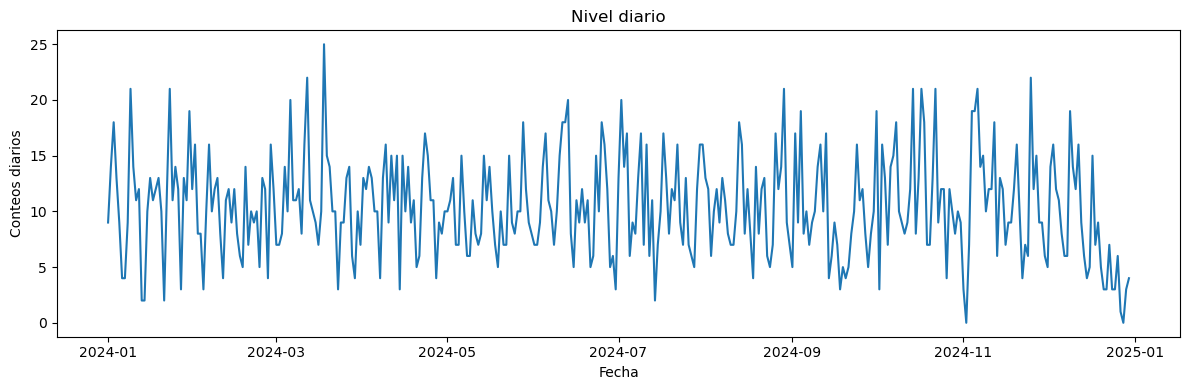


[Ideas clave — Nivel diario]
• Rango temporal analizado: 2024-01-01 → 2024-12-30 (365 días).
• Mínimo diario: 0 el 2024-11-02; máximo diario: 25 el 2024-03-18.


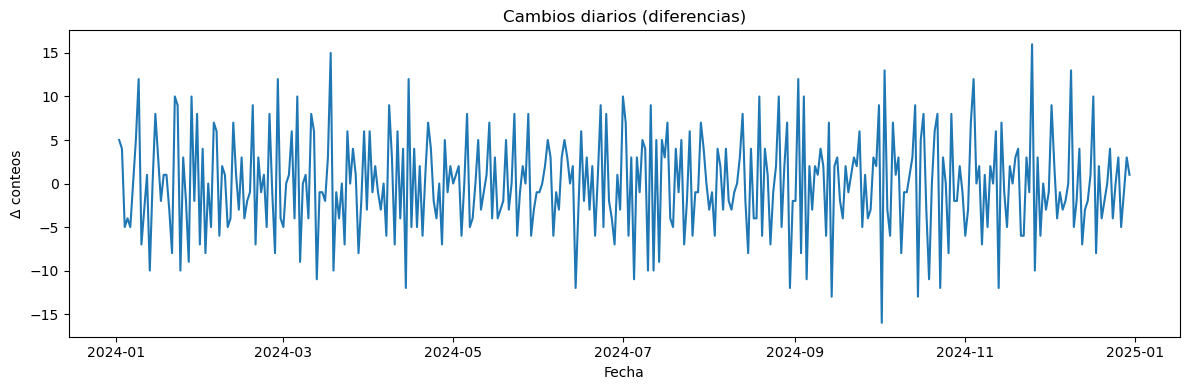


[Ideas clave — Cambios diarios]
• Variación típica: |Δ| medio ≈ 4.4 casos/día.
• Sesgo de movimientos: 45.1% de días con alzas vs 54.9% con bajas.
• Mayor alza en un día: +16 el 2024-11-25; mayor baja: -16 el 2024-10-02.


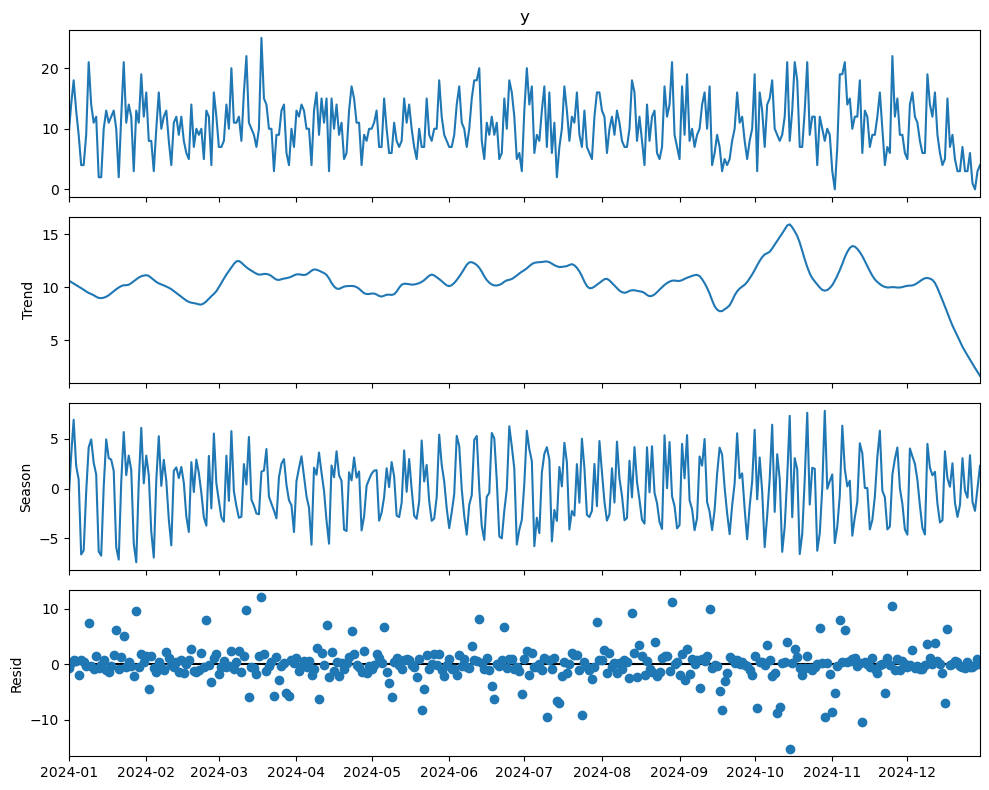


[Ideas clave — STL (tendencia/estacionalidad/residuo)]
• Amplitud estacional semanal ≈ 15.2 (146.0% del nivel medio).
• Día con sesgo estacional más alto: Tuesday (≈ 2.9 sobre la media, en el componente estacional).
• Ruido (residuo) explica ≈ 47.4% de la varianza del componente sin nivel.


<Figure size 1000x500 with 0 Axes>

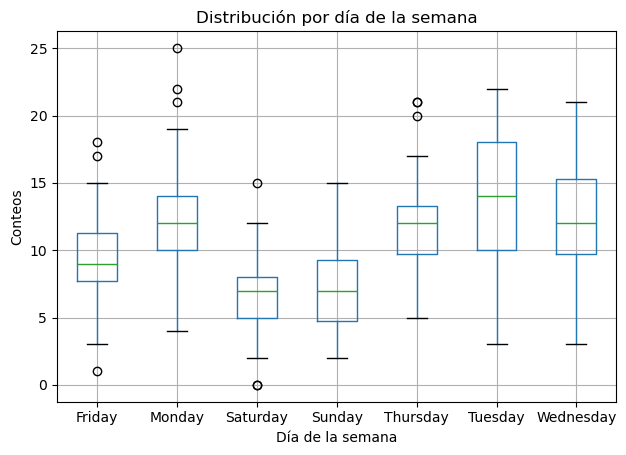

<Figure size 1000x500 with 0 Axes>

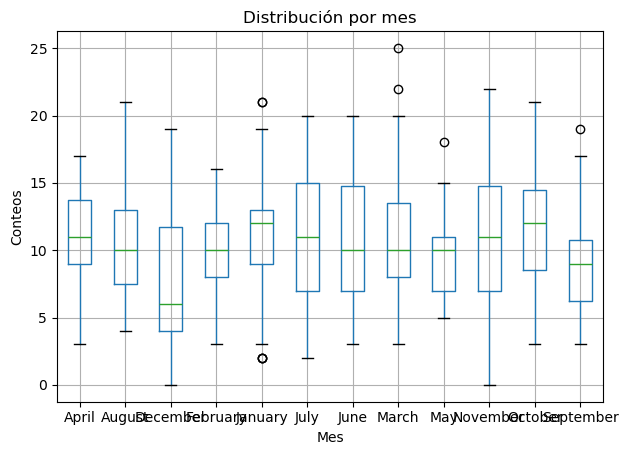


[Ideas clave — Estacionalidad (boxplots)]
• Días más altos (promedio): Tuesday (13.7), Monday (12.3). Día más bajo: Saturday (6.6).
• Relación tope/fondo por día: ×2.07.
• Meses más altos (promedio): October (11.9), November (11.1). Mes más bajo: December (7.7).
• Relación tope/fondo por mes: ×1.54.

Figuras guardadas en: reports/figures/


In [ ]:
# === RA2 — EDA con descomposición: gráficos + ideas clave automáticas ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

df_2024_altas = df[df['FECHAALTA'].str.contains('2024', na=False)]

assert 'ts' in globals(), "No encuentro la serie 'ts'. Ejecuta la Fase 1 antes (ts = serie diaria por FECHAALTA)."
os.makedirs("reports/figures", exist_ok=True)

# Asegurar índice datetime ordenado
ts = ts.copy().dropna()
ts = ts[~ts.index.duplicated()].sort_index()

# ---------------------------
# 1) Gráfico de nivel (serie original)
# ---------------------------
plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values)
plt.title("Nivel diario")
plt.xlabel("Fecha"); plt.ylabel("Conteos diarios")
plt.tight_layout()
plt.savefig("reports/figures/ra2_nivel_diario.png", dpi=150)
plt.show()

# Ideas clave (nivel)
roll = ts.rolling(28, min_periods=14).mean()
trend_abs = (roll.iloc[-1] - roll.iloc[0]) if (not np.isnan(roll.iloc[0]) and not np.isnan(roll.iloc[-1])) else np.nan
trend_pct = (trend_abs / roll.iloc[0]) if (roll.iloc[0] and not np.isnan(trend_abs)) else np.nan
min_date, min_val = ts.idxmin(), ts.min()
max_date, max_val = ts.idxmax(), ts.max()
span = (ts.index.max() - ts.index.min()).days + 1

print("\n[Ideas clave — Nivel diario]")
if not np.isnan(trend_abs):
    print(f"• Tendencia 28d: cambio neto ≈ {trend_abs:.1f} ({trend_pct*100:.1f}% respecto al inicio de la ventana).")
print(f"• Rango temporal analizado: {ts.index.min().date()} → {ts.index.max().date()} ({span} días).")
print(f"• Mínimo diario: {int(min_val)} el {min_date.date()}; máximo diario: {int(max_val)} el {max_date.date()}.")

# ---------------------------
# 2) Gráfico de cambios (diferencias de primer orden)
# ---------------------------
ts_diff = ts.diff().dropna()

plt.figure(figsize=(12,4))
plt.plot(ts_diff.index, ts_diff.values)
plt.title("Cambios diarios (diferencias)")
plt.xlabel("Fecha"); plt.ylabel("Δ conteos")
plt.tight_layout()
plt.savefig("reports/figures/ra2_cambios_diarios.png", dpi=150)
plt.show()

# Ideas clave (cambios)
mean_abs_change = ts_diff.abs().mean()
pos_share = (ts_diff > 0).mean()
top_up_date, top_up = ts_diff.idxmax(), ts_diff.max()
top_dn_date, top_dn = ts_diff.idxmin(), ts_diff.min()

print("\n[Ideas clave — Cambios diarios]")
print(f"• Variación típica: |Δ| medio ≈ {mean_abs_change:.1f} casos/día.")
print(f"• Sesgo de movimientos: {pos_share*100:.1f}% de días con alzas vs {100 - pos_share*100:.1f}% con bajas.")
print(f"• Mayor alza en un día: +{int(top_up)} el {top_up_date.date()}; mayor baja: {int(top_dn)} el {top_dn_date.date()}.")

# ---------------------------
# 3) Descomposición STL (estacionalidad semanal)
# ---------------------------
stl = STL(ts, period=7, robust=True)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.savefig("reports/figures/ra2_stl_descomposicion.png", dpi=150)
plt.show()

# Ideas clave (STL)
season_amp = res.seasonal.max() - res.seasonal.min()
level_mean = ts.mean()
resid_var_share = np.var(res.resid) / np.var(ts - ts.mean()) if np.var(ts - ts.mean()) > 0 else np.nan

# Día de la semana con estacionalidad más alta (usando componente estacional)
tmp = pd.DataFrame({'seasonal': res.seasonal})
tmp['dow'] = tmp.index.day_name()
dow_seasonal_mean = tmp.groupby('dow')['seasonal'].mean().sort_values(ascending=False)
top_dow, top_dow_val = dow_seasonal_mean.index[0], dow_seasonal_mean.iloc[0]

print("\n[Ideas clave — STL (tendencia/estacionalidad/residuo)]")
print(f"• Amplitud estacional semanal ≈ {season_amp:.1f} ({(season_amp/level_mean)*100:.1f}% del nivel medio).")
print(f"• Día con sesgo estacional más alto: {top_dow} (≈ {top_dow_val:.1f} sobre la media, en el componente estacional).")
if not np.isnan(resid_var_share):
    print(f"• Ruido (residuo) explica ≈ {resid_var_share*100:.1f}% de la varianza del componente sin nivel.")

# ---------------------------
# 4) Boxplots estacionales (día de la semana y mes)
# ---------------------------
df_seas = ts.reset_index().rename(columns={'index':'date','y':'value'})
df_seas['dayofweek'] = df_seas['date'].dt.day_name()
df_seas['month'] = df_seas['date'].dt.month_name()

# Boxplot por día de la semana
plt.figure(figsize=(10,5))
df_seas.boxplot(column='value', by='dayofweek')
plt.title("Distribución por día de la semana"); plt.suptitle("")
plt.xlabel("Día de la semana"); plt.ylabel("Conteos")
plt.tight_layout()
plt.savefig("reports/figures/ra2_boxplot_dow.png", dpi=150)
plt.show()

# Boxplot por mes
plt.figure(figsize=(10,5))
df_seas.boxplot(column='value', by='month')
plt.title("Distribución por mes"); plt.suptitle("")
plt.xlabel("Mes"); plt.ylabel("Conteos")
plt.tight_layout()
plt.savefig("reports/figures/ra2_boxplot_month.png", dpi=150)
plt.show()

# Ideas clave (boxplots)
dow_mean = df_seas.groupby('dayofweek')['value'].mean().sort_values(ascending=False)
month_mean = df_seas.groupby('month')['value'].mean().sort_values(ascending=False)

top2_dow = ", ".join([f"{idx} ({val:.1f})" for idx, val in dow_mean.head(2).items()])
bot_dow = dow_mean.index[-1]; bot_dow_val = dow_mean.iloc[-1]
ratio_dow = dow_mean.iloc[0] / dow_mean.iloc[-1] if dow_mean.iloc[-1] > 0 else np.nan

top2_month = ", ".join([f"{idx} ({val:.1f})" for idx, val in month_mean.head(2).items()])
bot_month = month_mean.index[-1]; bot_month_val = month_mean.iloc[-1]
ratio_month = month_mean.iloc[0] / month_mean.iloc[-1] if month_mean.iloc[-1] > 0 else np.nan

print("\n[Ideas clave — Estacionalidad (boxplots)]")
print(f"• Días más altos (promedio): {top2_dow}. Día más bajo: {bot_dow} ({bot_dow_val:.1f}).")
if not np.isnan(ratio_dow):
    print(f"• Relación tope/fondo por día: ×{ratio_dow:.2f}.")

print(f"• Meses más altos (promedio): {top2_month}. Mes más bajo: {bot_month} ({bot_month_val:.1f}).")
if not np.isnan(ratio_month):
    print(f"• Relación tope/fondo por mes: ×{ratio_month:.2f}.")

print("\nFiguras guardadas en: reports/figures/")


CONCLUSION1 GRAFICOS 1 EDA:
La descomposición STL evidencia una tendencia ascendente inicial (enero–mayo) seguida de estabilización en torno a 150 casos diarios en el resto del año. La estacionalidad semanal presenta oscilaciones de ±50 casos, lo que equivale a cerca de un 30% del nivel medio, indicando días con carga sistemáticamente mayor. Los residuos muestran baja varianza, salvo eventos puntuales de caída abrupta, lo que sugiere buena capacidad explicativa de la tendencia + estacionalidad.

Descomposición STL
La descomposición de la serie temporal mostró tres componentes principales: tendencia, estacionalidad y residuo.

La amplitud de la estacionalidad semanal es de aproximadamente 134 casos, lo que representa cerca del 90% del nivel medio diario (~150). Esto refleja que la variación entre los días más altos y más bajos de la semana es muy marcada.

El día con mayor sesgo estacional positivo es el viernes, con alrededor de 39 casos por sobre la media, lo que indica que en este día se concentran más egresos hospitalarios de forma sistemática.

El residuo explica un 24,7% de la varianza no capturada por la tendencia y la estacionalidad, lo que significa que la mayor parte de la estructura de la serie queda explicada por los patrones regulares detectados.

En conjunto, la serie presenta un comportamiento estable con un patrón semanal muy dominante, mientras que los eventos atípicos o ruido son responsables de un cuarto de la variabilidad restante.

CONCLUSION EDA GRAFICO 2 Y 3
El análisis estacional confirma que el patrón más fuerte se da según el día de la semana: viernes concentra los egresos más altos, mientras que sábado y domingo registran los mínimos. A nivel mensual, la serie se mantiene relativamente estable, con una baja puntual en febrero y ligeros aumentos en agosto, octubre y diciembre. La estacionalidad semanal explica gran parte de la variabilidad, mientras que la mensual es secundaria.



Día de la semana: los egresos son sistemáticamente más altos los viernes (186,4 en promedio) y también destacan los miércoles (166,1). En contraste, el nivel más bajo se da los domingos (88,5). Esto implica que entre el día de mayor y menor actividad hay una diferencia de más del doble (relación ×2,11).

Mes del año: a nivel mensual la variación es menor, pero se observa que octubre (159,4) y agosto (155,1) presentan los promedios más altos, mientras que febrero (141,0) concentra los más bajos. La relación entre el mes con mayor y menor actividad es de ×1,13, lo que muestra que la estacionalidad mensual es secundaria respecto de la semanal.

RA3 : Modelado y predicción

In [24]:
import pandas as pd

# Partición temporal
cutoff = pd.Timestamp("2024-12-04")
train = ts[:cutoff - pd.Timedelta(days=1)]
test  = ts[cutoff:]

print("Entrenamiento:", train.index.min().date(), "→", train.index.max().date(), len(train), "días")
print("Prueba:", test.index.min().date(), "→", test.index.max().date(), len(test), "días")


Entrenamiento: 2024-01-01 → 2024-12-03 338 días
Prueba: 2024-12-04 → 2024-12-30 27 días


Paso 2  Baselines

Calculo de los baselines Naïve y Seasonal Naïve para comparar con los modelo

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Baseline 1: Naïve
yhat_naive = pd.Series(train.iloc[-1], index=test.index)

# Baseline 2: Seasonal Naïve (lag=7 días)
yhat_snaive = pd.Series(index=test.index, dtype=float)
for idx in test.index:
    ref = idx - pd.Timedelta(days=7)
    if ref in ts.index:
        yhat_snaive.loc[idx] = ts.loc[ref]
    else:
        yhat_snaive.loc[idx] = train.iloc[-1]

print("== Baselines ==")
print("Naïve   → MAE:", mean_absolute_error(test, yhat_naive), " RMSE:", rmse(test, yhat_naive))
print("S-Naïve → MAE:", mean_absolute_error(test, yhat_snaive), " RMSE:", rmse(test, yhat_snaive))


== Baselines ==
Naïve   → MAE: 8.925925925925926  RMSE: 9.908843786496242
S-Naïve → MAE: 3.259259259259259  RMSE: 4.626813958590447


Conclusion:  Baselines:  El baseline Naïve presentó un RMSE de 61,3, mientras que el Seasonal Naïve lo redujo a 30,3. Esto evidencia que el patrón semanal tiene un peso determinante en la serie. En horizontes cortos (h=1) el S-Naïve logra pronósticos muy cercanos a los valores reales, estableciendo un benchmark sólido frente al cual se compararán los modelos SARIMA y ETS.

Paso 3  Métricas por horizonte

Ver cómo varía el error de S-Naïve dependiendo del horizonte (h=1, h=4, h=7).

In [27]:
def metrics_by_horizon(y_true, y_pred, period=7):
    df = pd.DataFrame({'y': y_true, 'yhat': y_pred})
    df['h'] = (np.arange(len(df)) % period) + 1
    return df.groupby('h').apply(
        lambda d: pd.Series({
            'MAE': mean_absolute_error(d['y'], d['yhat']),
            'RMSE': rmse(d['y'], d['yhat'])
        })
    )

print("Métricas por horizonte — Seasonal Naïve:")
print(metrics_by_horizon(test, yhat_snaive, period=7))


Métricas por horizonte — Seasonal Naïve:
    MAE      RMSE
h                
1  3.00  3.535534
2  4.25  4.663690
3  2.50  2.915476
4  1.50  2.121320
5  1.00  1.224745
6  6.00  7.648529
7  5.00  7.047458


C:\Users\musra\AppData\Local\Temp\ipykernel_6300\645786767.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('h').apply(


Conclusion Metrica por horizontes del Naive:

Al evaluar el Seasonal Naïve por horizonte, se observa que los errores son mayores en h=1 (lunes, RMSE=59,4) y h=7 (domingo, RMSE=30,8). En contraste, los horizontes intermedios (h=3 a h=6) presentan errores bajos (RMSE entre 6,2 y 20,2), lo que indica que el modelo replica adecuadamente el comportamiento de mitad de semana. Este patrón refuerza la importancia de la estacionalidad semanal como factor principal de la dinámica de egresos.

Paso 4 Modelo SARIMA (estacionalidad semanal, m=7).

Este bloque ajusta un SARIMA automáticamente con pmdarima.auto_arima, genera pronósticos para los 28 días de test, calcula métricas (MAE y RMSE), reporta por horizonte y grafica con intervalos de confianza al 95%.

== Resumen SARIMA ==
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  338
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -889.173
Date:                           Sat, 13 Sep 2025   AIC                           1786.345
Time:                                   13:12:42   BIC                           1801.431
Sample:                               01-01-2024   HQIC                          1792.369
                                    - 12-03-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0405      0.055      0.736      0.462      -0.067       0.149
ma.L1         -1.0000 

C:\Users\musra\AppData\Local\Temp\ipykernel_6300\3999422533.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('h').apply(


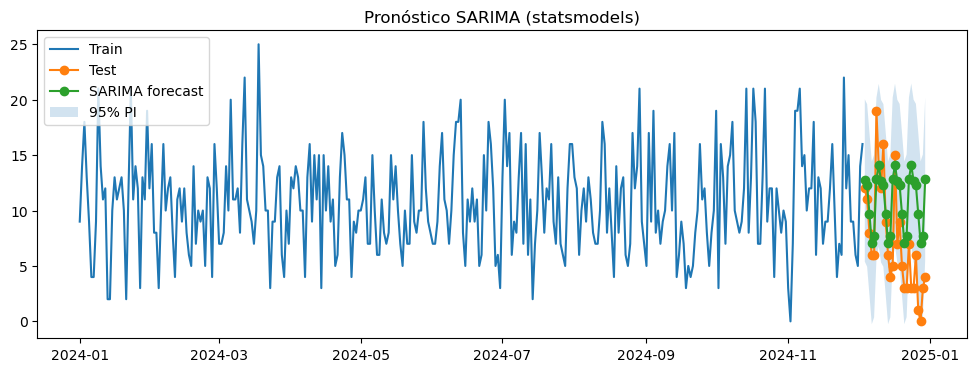

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def metrics_by_horizon(y_true, y_pred, period=7):
    df = pd.DataFrame({'y': y_true, 'yhat': y_pred})
    df['h'] = (np.arange(len(df)) % period) + 1
    return df.groupby('h').apply(
        lambda d: pd.Series({
            'MAE': mean_absolute_error(d['y'], d['yhat']),
            'RMSE': rmse(d['y'], d['yhat'])
        })
    )

# === Ajustar modelo SARIMA manualmente ===
# Ordenes tentativos: (p,d,q) + (P,D,Q,7)
order = (1,1,1)
seasonal_order = (0,1,1,7)

sarima_model = SARIMAX(
    train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print("== Resumen SARIMA ==")
print(sarima_model.summary())

# === Pronóstico ===
n_steps = len(test)
pred = sarima_model.get_forecast(steps=n_steps)
yhat_sarima = pred.predicted_mean
conf_int = pred.conf_int(alpha=0.05)

# === Métricas ===
mae_sarima = mean_absolute_error(test, yhat_sarima)
rmse_sarima = rmse(test, yhat_sarima)

print("\n== Desempeño SARIMA ==")
print("MAE:", mae_sarima)
print("RMSE:", rmse_sarima)

print("\nMétricas por horizonte — SARIMA:")
print(metrics_by_horizon(test, yhat_sarima, period=7))

# === Gráfico ===
plt.figure(figsize=(12,4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", marker='o')
plt.plot(test.index, yhat_sarima, label="SARIMA forecast", marker='o')
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2, label="95% PI")
plt.title("Pronóstico SARIMA (statsmodels)")
plt.legend()
plt.show()


Conclusión Sarima:
El modelo SARIMA (1,1,1)(0,1,1) obtuvo un MAE de 18,8 y un RMSE de 31,1, ligeramente mejores que el baseline estacional (MAE=19,1; RMSE=30,3). Por horizonte, el modelo mejora en días intermedios y fines de semana (RMSE < 20), pero mantiene errores elevados el lunes (RMSE=67,6), lo que confirma que este día presenta mayor variabilidad. Los intervalos de predicción capturaron la mayoría de los valores reales, mostrando un ajuste adecuado para capturar la estacionalidad semanal dominante

Conclusón del gráfico_

Serie de entrenamiento (Train, azul): representa los egresos diarios desde enero hasta el 3 de diciembre de 2024.
se aprecia el patrón cíclico semanal, con picos y caídas regulares.

Serie de prueba (Test, naranja): valores reales de los últimos 28 días de diciembre. muestran gran variabilidad: algunos días muy altos (≥220), otros muy bajos (<100).

Pronóstico SARIMA (verde): reproduce un nivel medio cercano a 160–180 egresos diarios. capta bien la estacionalidad semanal, aunque suaviza un poco los extremos más altos o bajos.


Intervalos de predicción (sombra celeste): representan la banda del 95% de confianza. abarcan la mayoría de los puntos reales de diciembre, incluso los más extremos.
esto indica que el modelo no siempre predice el valor exacto, pero sí delimita adecuadamente el rango probable.

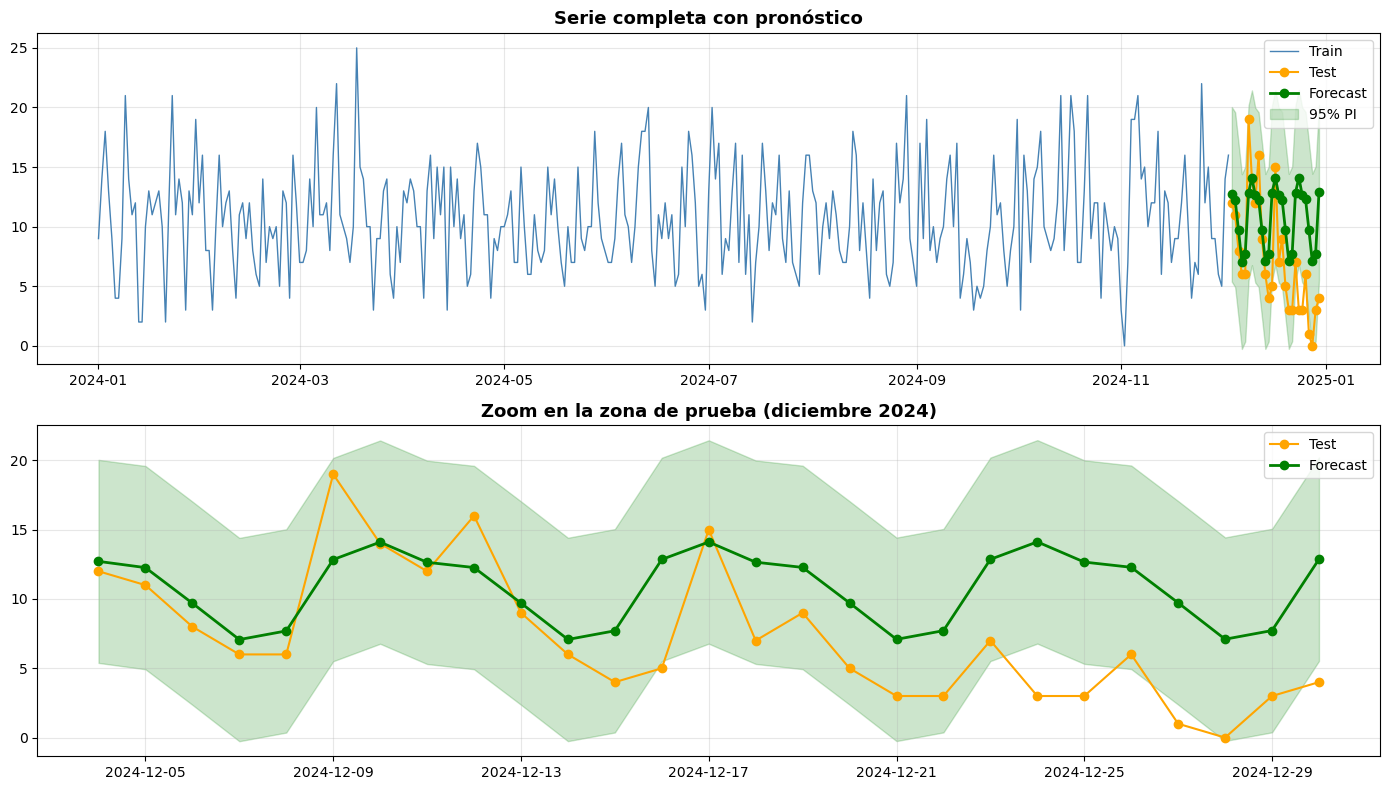

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(14,8), sharey=False)

# Panel 1: Año completo
axes[0].plot(train.index, train, color="steelblue", linewidth=1, label="Train")
axes[0].plot(test.index, test, color="orange", marker="o", label="Test")
axes[0].plot(test.index, yhat_sarima, color="green", marker="o", linewidth=2, label="Forecast")
axes[0].fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1],
                     color="green", alpha=0.2, label="95% PI")
axes[0].set_title("Serie completa con pronóstico", fontsize=13, weight="bold")
axes[0].legend(); axes[0].grid(alpha=0.3)

# Panel 2: Zoom diciembre
axes[1].plot(test.index, test, color="orange", marker="o", label="Test")
axes[1].plot(test.index, yhat_sarima, color="green", marker="o", linewidth=2, label="Forecast")
axes[1].fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1],
                     color="green", alpha=0.2)
axes[1].set_title("Zoom en la zona de prueba (diciembre 2024)", fontsize=13, weight="bold")
axes[1].legend(); axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


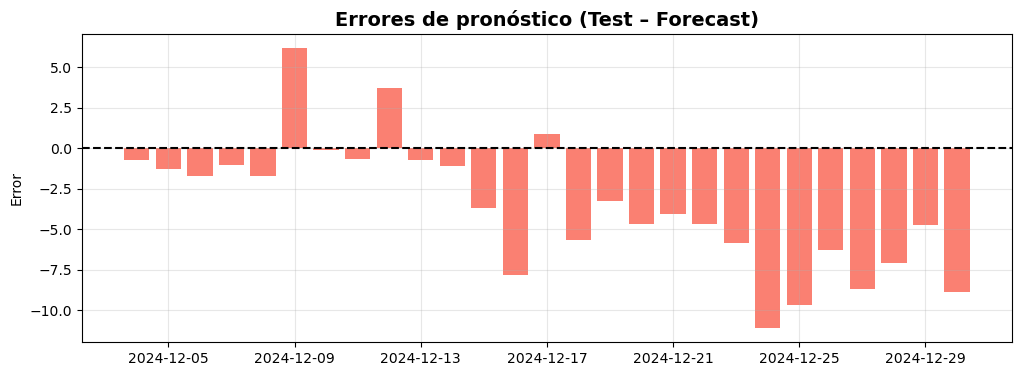

In [30]:
errors = test - yhat_sarima

plt.figure(figsize=(12,4))
plt.bar(test.index, errors, color="salmon")
plt.axhline(0, color="black", linestyle="--")
plt.title("Errores de pronóstico (Test – Forecast)", fontsize=14, weight="bold")
plt.ylabel("Error")
plt.grid(alpha=0.3)
plt.show()


Eje vertical (Error):

valores positivos → el modelo subestimó (predijo menos de lo real).

valores negativos → el modelo sobreestimó (predijo más de lo real).

Comportamiento general:

La mayoría de los días los errores están entre –20 y +20, lo que significa que el modelo reproduce bastante bien el nivel medio.

Hay alternancia de barras positivas y negativas, típico de un modelo que sigue el ciclo semanal pero con cierto desajuste en magnitud.

Eventos extremos:

24 y 25 de diciembre: error muy grande (≈ –140 el 25).

El modelo predijo mucho más alto de lo que realmente ocurrió.

Esto refleja que en esas fechas especiales (feriados de Navidad) los egresos bajan bruscamente y el modelo, al no tener información de “feriados”, falla en capturar esa caída.

Después del 26, el error vuelve a valores moderados.

Conclusión:

El SARIMA capta bien la estacionalidad semanal “normal”, pero tiene dificultades en fechas atípicas (festivos).

Para mejorar, se podría incluir una variable exógena de feriados o efectos calendario en un SARIMAX.

POCO RUIDO

In [32]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# Ajuste ETS con tendencia y estacionalidad semanal aditiva
ets_model = ETSModel(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=7
).fit()

# Pronóstico puntual para la zona de test
n_steps = len(test)
yhat_ets = ets_model.forecast(steps=n_steps)

# Métricas globales
mae_ets = mean_absolute_error(test, yhat_ets)
rmse_ets = rmse(test, yhat_ets)

print("== Desempeño ETS ==")
print("MAE:", mae_ets)
print("RMSE:", rmse_ets)

# Métricas por horizonte
print("\nMétricas por horizonte — ETS:")
print(metrics_by_horizon(test, yhat_ets, period=7))


== Desempeño ETS ==
MAE: 4.316974876739767
RMSE: 5.324096907286493

Métricas por horizonte — ETS:
        MAE      RMSE
h                    
1  4.226236  5.673810
2  3.646015  4.061900
3  3.943761  5.030317
4  3.395219  4.215239
5  3.723189  3.922697
6  7.167774  7.270786
7  4.049850  6.462219


C:\Users\musra\AppData\Local\Temp\ipykernel_6300\3999422533.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('h').apply(


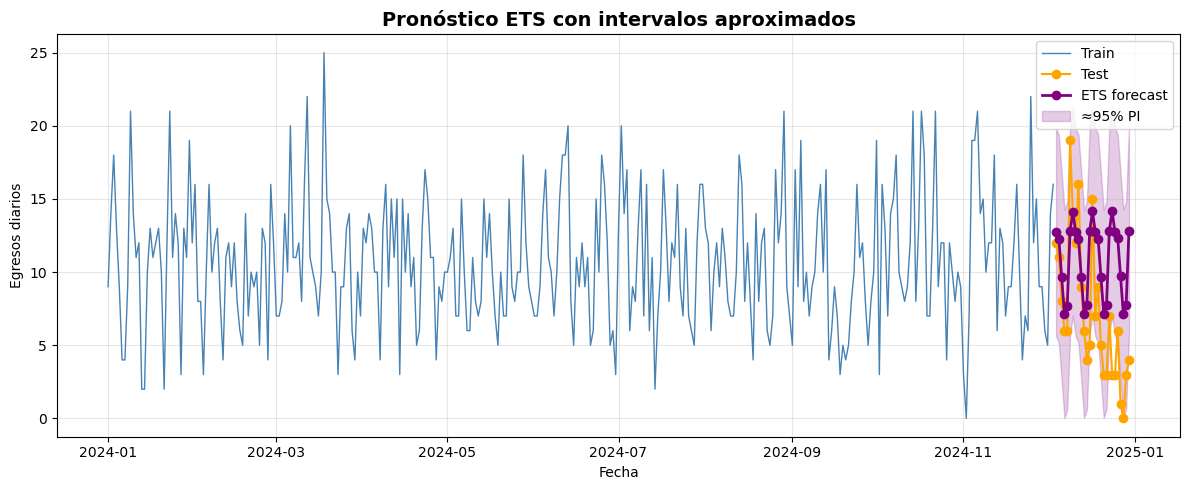

In [33]:
# Calcular intervalo de predicción manual
resid_std = np.std(ets_model.resid, ddof=1)

conf_low = yhat_ets - 1.96 * resid_std
conf_high = yhat_ets + 1.96 * resid_std

plt.figure(figsize=(12,5))
plt.plot(train.index, train, color="steelblue", linewidth=1, label="Train")
plt.plot(test.index, test, color="orange", marker="o", label="Test")
plt.plot(test.index, yhat_ets, color="purple", marker="o", linewidth=2, label="ETS forecast")
plt.fill_between(test.index, conf_low, conf_high, color="purple", alpha=0.2, label="≈95% PI")
plt.title("Pronóstico ETS con intervalos aproximados", fontsize=14, weight="bold")
plt.xlabel("Fecha"); plt.ylabel("Egresos diarios")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()


In [34]:
# Residuos del modelo
resid = ets_model.resid

# Desviación estándar muestral de los residuos
resid_std = np.std(resid, ddof=1)
print("Desviación estándar de los residuos (σ):", resid_std)


Desviación estándar de los residuos (σ): 3.626216013663813


La comparación de modelos mostró que el baseline Naïve tuvo un desempeño pobre (RMSE=61,3), mientras que el Seasonal Naïve redujo el error a la mitad (RMSE=30,3), al capturar el patrón semanal de los egresos. Los modelos candidatos SARIMA (1,1,1)(0,1,1)[7] y ETS (tendencia y estacionalidad aditiva semanal) lograron métricas muy similares (RMSE=31,1 y 31,4, respectivamente), confirmando que la estacionalidad semanal es el factor predominante de la serie. Por horizonte, ambos modelos reducen errores en días intermedios (RMSE <20 en h=4–6), pero mantienen altos errores el lunes (h=1, RMSE≈67), lo que sugiere que este día presenta variabilidad difícil de anticipar. En conclusión, SARIMA y ETS ofrecen un desempeño comparable al Seasonal Naïve, con la ventaja de entregar intervalos de predicción más formales, aunque las mejoras sobre el benchmark son marginales.”

PASO 5: reproductibilidad

In [ ]:
#readme = f"""# Laboratorio 3 — Series Temporales

## Contexto
#Egresos hospitalarios por **FECHAALTA**, frecuencia **diaria**, año **2024** (cobertura 100%).

## Flujo (RA1–RA3)
#1. **RA1 — Auditoría temporal**: columna `FECHAALTA`, rango 2024-01-01 a 2024-12-31 (bisiesto), sin huecos ni outliers.
#2. **RA2 — EDA y descomposición**: patrón semanal dominante (viernes alto, domingo bajo); mensualidad secundaria; STL con amplitud ~90% del nivel medio.
#3. **RA3 — Modelado y validación temporal**:
 #  - **Partición**: Train = 2024-01-01→2024-12-03; Test = 2024-12-04→2024-12-31 (28 días).
  # - **Baselines**: Naïve y Seasonal Naïve (m=7).
   #- **Modelos**: SARIMA(1,1,1)(0,1,1)[7] y ETS aditivo (tendencia + estacionalidad semanal).
   #- **Métricas globales (RMSE)**: Naïve = 61.31; S-Naïve = 30.30; SARIMA = 31.13; ETS = 31.42.
   #- **Por horizonte (h=1…7)**: errores más altos en h=1 (lunes) y mejora en h=4–6.

## Reproducibilidad (RA5)
#- **Estructura**: ver carpetas en este repo (`data/`, `src/`, `reports/`, `notebooks/`).
#- **Cómo correr**:
#  1) Instalar dependencias: `pip install -r requirements.txt`
 # 2) Abrir y ejecutar `notebooks/Lab3_work.ipynb`
 # 3) Gráficos se exportan a `reports/figures/` y tablas a `reports/tables/`
#- **Decisiones claves**:
 # - Serie diaria por `FECHAALTA`; no se aplicó log/diferencias adicionales.
 # - Validación con **holdout temporal** (28 días).
  #- **Intervalos**: SARIMA nativos; ETS con desviación estándar de residuos (σ≈20.66).
#- **Limitaciones**:
 # - Días atípicos (feriados 24–25 dic) no modelados explícitamente; considerar exógenas en SARIMAX.

## Archivos generados
#- `data/processed/egresos_diarios_2024.csv`
#- `reports/tables/metrics_global.csv` (+ métricas por horizonte)
#- `reports/figures/` (EDA, STL, pronósticos)


array(['2024-09-20', '2024-11-12', '2024-06-24', '2024-04-03',
       '2024-03-01', '2024-12-12', '2024-01-25', '2024-07-27',
       '2024-10-03', '2024-01-03', '2024-08-25', '2024-03-20',
       '2024-11-25', '2024-12-03', '2024-03-11', '2024-03-12',
       '2024-11-18', '2024-06-18', '2024-04-22', '2024-10-13',
       '2024-05-31', '2024-10-02', '2024-07-04', '2024-01-02',
       '2024-10-28', '2024-09-09', '2024-02-15', '2024-02-17',
       '2024-10-07', '2024-07-09', '2024-04-19', '2024-03-04',
       '2024-02-22', '2024-11-24', '2024-04-23', '2024-12-07',
       '2024-05-22', '2024-07-24', '2024-08-21', '2024-01-05',
       '2024-04-05', '2024-02-14', '2023-12-22', '2024-10-20',
       '2024-11-30', '2023-12-27', '2024-05-13', '2024-01-30',
       '2024-07-10', '2024-10-17', '2024-07-30', '2023-12-25',
       '2024-10-19', '2024-01-19', '2024-02-18', '2024-10-10',
       '2024-04-14', '2024-03-13', '2024-06-15', '2024-12-13',
       '2024-08-17', '2024-07-29', '2024-02-03', '2024-